# Noise Filtering for XENONnT Waveforms

Sam Li, Rice U.

In this notebook, we are going to introduce different filters to reduce noise for XENON waveforms. The goal is to effectively reduce noise, or in other words, increase SNR; in this way we won't harm the quality of signals in future analytic operations, ie: Compression. 

Firstly, import necessary libraries. 

In [1]:
import random
import strax
import straxen
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal

With necessary packages imported, let load some data and take a look at it:

Experiment 180219_0946 is an experiment that records noises in the channel. Each sample in rr_noise is a long signal where no pulse should be seen. We are loading this data to understand the properties of noises. 

Experiment 180215_1035 on the other hand, is a hour-long recording that contains several high quality data. It will be out primary material to study with. 

In [2]:
st = straxen.contexts.xenon1t_dali()
rr_noise = st.get_array('180219_0946','raw_records', seconds_range=(0, 0.1))
rr = st.get_array('180215_1035','raw_records', seconds_range=(0, 0.1))

To understand the structure of our data, we can do the following:

In [3]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (w...
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this ...
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


In [4]:
rr[0]

(1518690942000126790, 104, 10, 113, 104, 0, 0, [16008, 16016, 16009, 16013, 16003, 16012, 16005, 16008, 15999, 16008, 16002, 16009, 16000, 16009, 16004, 16014, 16004, 16012, 16006, 16015, 16009, 16015, 16005, 16013, 16005, 16013, 16006, 16008, 16002, 16005, 16001, 16010, 16007, 16011, 16003, 16009, 16005, 16014, 16008, 16015, 16007, 16012, 16008, 16014, 16008, 16011, 16003, 16010, 16003, 16008, 15982, 15938, 15976, 16003, 16000, 16007, 16002, 16012, 16004, 16012, 16006, 16012, 16005, 16010, 16001, 16011, 16002, 16007, 16001, 16008, 16003, 16008, 16001, 16009, 16004, 16011, 16006, 16014, 16007, 16014, 16006, 16010, 16004, 16011, 16006, 16012, 16006, 16010, 16003, 16007, 16002, 16009, 16003, 16009, 16003, 16012, 16008, 16014, 16008, 16013, 16004, 16011, 16005, 16013,     0,     0,     0,     0,     0,     0])

To improve the quality of our data, we can do some quick processing to rr:

In [287]:
record = strax.raw_to_records(rr)
record_noise = strax.raw_to_records(rr_noise)

strax.baseline(record)
strax.baseline(record_noise)

#Here we define two variables, sample noise and sample data, representing the 0th sample of noise recordings in
#channel 0 and the 0th sample of signal recordings in channel 0. 
sample_noise = record_noise[0]
sample_data = record[record["channel"] == 0][0]


# 1. 1D Gaussian Filter

Now let's begin filtering. By assumption, we would say that noises in our channel is gaussian, one of the best guesses for random noises. Therefore applying a 1D gaussian filter will be reasonble. The idea behind this filter is to take a sigma-valued gaussian kernel and convolve it with the original signal. If the sigma is properly chosen (based on the level of noise), noise components in the signal will be eliminated and what's left are pulses (deducted by certain gaussian kernels). 

As a general approach, we should pick sigma to be the standard deviation of noises (sample_noise) to gain satisfying results. 

After the filtering, what's left are peaks, whose positions are exactly where the delta pulses are located in the original signal. We then do find_peaks() for the remainder signal to obtain the "signal positions", and therefore keeping these positions (and throwing away the noises). Let's see how this works:

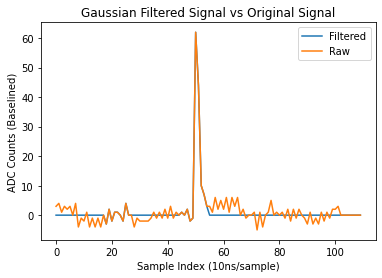

In [32]:
ft = scipy.ndimage.filters.gaussian_filter1d(sample_data[-1], np.std(sample_noise[-1]))

#After filtering, we locates the peaks in the remaining signal. By now all noise terms should already be 
#eliminated. Therefore the leftover peaks should be the location of the pulses. 
peaks, _ = signal.find_peaks(ft)

#Now we keep the 5 nearest neighbors of each peak, and set the rest of the signal to be 0, where we think 
#are positions of noises. 
result = [0]*110
for peak in peaks:
    result[peak-5:peak+5] = sample_data[-1][peak-5:peak+5]

#Let's plot them and see results. 
plt.plot(result, label='Filtered')
plt.plot(sample_data[-1], label='Raw')
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Gaussian Filtered Signal vs Original Signal")
plt.legend()
plt.show()

# 1.1 Applicability of Algorithm

While the algorithm worked well for the sample above, a big question that lies in front of us is that: Would this approach work for all samples? What if some samples are really bad? What if there are more than one pulses in the waveform?

To answer these questions, let's randomly choose a sample from record and see the difference before and after filtering. 

10
[ 16  26  41  52  69  80  88 102]


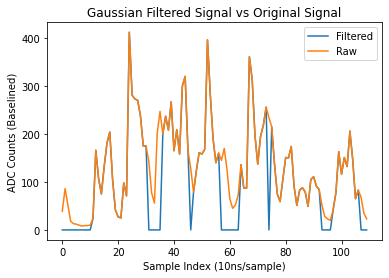

CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 187 ms


In [117]:
%%time
# import random at the beginning not here.
ch0 = record[record["channel"] == 0]
ran_index = random.randrange(0, len(ch0))
print (ran_index)

ft_new = scipy.ndimage.filters.gaussian_filter1d(ch0[ran_index][-1], np.std(sample_noise[-1]))
peaks, _ = signal.find_peaks(ft_new)
print (peaks)

result = np.array([0]*110)
for peak in peaks:
    result[peak-5:peak+5] = ch0[ran_index][-1][peak-5:peak+5]

plt.plot(result, label='Filtered')
plt.plot(ch0[ran_index][-1], label='Raw')
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Gaussian Filtered Signal vs Original Signal")
plt.legend()
plt.show()

As we can see above, the waveform is rather chaotic and contains multple peaks. Our algorithm was able to find these peaks and perform noise reduction on it.

Great results. Please note that this approch is channel-specfic: using noise samples from other channels might result in problematic filtering. 

Now let's evaluate the speed performance of this filter.

# 1.2 Speed of Gaussian Filter

While we just saw the system runtime of gaussian filtering one sample (and plotting it), let's wrap the algorithm above into one function and apply it to multiple samples, for example, all sample in a specfic channel in a run (record). 

In [76]:
def gaussian_filter(record, channel_id, noise_record):
    #Aruguments:
    #Record: The baselined run data
    #Channel_id: The id of the channel
    #Noise_record: The baselined noise data
    noise = noise_record[noise_record["channel"] == channel_id][-1]
    std_noise = np.std(noise[-1])
    
    record_channelx = record[record["channel"] == channel_id]
    for s in record_channelx:
        f = scipy.ndimage.filters.gaussian_filter1d(s[-1], std_noise)
        pks, prop = signal.find_peaks(f)
        if len(pks) == 0:
            continue
        result = np.array([0]*110)
        for p in pks:
            result[p-5:p+5] = s[-1][p-5:p+5]
        s[-1] = result
    return record_channelx


In [80]:
%%time
#Now let's see the speed of this filter, firstly, let's try one random channel:
ch_id = 96 #random pick a channel id; feel free to try other channels
filtered_ch96 = gaussian_filter(record, ch_id, record_noise)

CPU times: user 20.9 ms, sys: 435 µs, total: 21.4 ms
Wall time: 19.3 ms


The speed is pretty good. Keep in mind that this is the processing time for one channel, now let's check the processing time for all channels:

In [157]:
#To make sure that the time we measured is the actual processing time, let's firstly group samples in record by channel; by doing this, let's create an
#array (of length 255), whereas each item is an array that contains all samples in the same channel. 
r_matrix = []
number_of_channels = max(record["channel"])
for id in range(number_of_channels+1):
    chx = record[record["channel"] == id]
    r_matrix.append(chx)

#let's make a copy of r_matrix for future use:
rm = []
number_of_channels = max(record["channel"])
for id in range(number_of_channels+1):
    chx = record[record["channel"] == id]
    rm.append(chx)


In [158]:
#And let's modify the gaussian filter function to optmize runtime:
def gaussian_filter_for_processed_record(r_matrix, noise_record):
    #Aruguments:
    #Record: The baselined run data
    #Noise_record: The baselined noise data
    channel_id_max = len(r_matrix)
    channel_id = 0
    for chx in r_matrix:
        if len(noise_record[noise_record["channel"] == channel_id]) == 0:
            noise = noise_record[noise_record["channel"] == 0][-1]  #if noise sample for a channel doesn't exist, use the noise in ch0 to approximate
        else: 
            noise = noise_record[noise_record["channel"] == channel_id][-1]
        std_noise = np.std(noise[-1])
    
        record_channelx = chx
        for s in record_channelx:
            f = scipy.ndimage.filters.gaussian_filter1d(s[-1], std_noise)
            pks, prop = signal.find_peaks(f)
            if len(pks) == 0:
                continue
            result = np.array([0]*110)
            for p in pks:
                result[p-5:p+5] = s[-1][p-5:p+5]
            s[-1] = result
        channel_id += 1
    return

In [159]:
%%time
#Now let's test it's speed
gaussian_filter_for_processed_record(r_matrix, record_noise)

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


The total runtime for record is around 1.3 seconds. To calculate the amortized runtime, let's repeat the operation above for 100 times:

In [114]:
%%time
for i in range(0,100): #feel free to try larger iteration times
    gaussian_filter_for_processed_record(r_matrix, record_noise)
    #print (i)

CPU times: user 1min 58s, sys: 55.1 ms, total: 1min 58s
Wall time: 1min 58s


Amortized runtime is 118/100 = 1.18s per iteration. This is pretty nice speed. 

# 1.3 Quality Check

So far we have examined the applicability and speed of our filter. In this section, we are going to conduct a quality analysis on our filter. Let's set a hard threshold to 10 (ADC counts) to the minimum heights in a waveform. Then we compute the area of a pulse using it's 10 nearest neighbors. 

On the other hand, we use our algorithm above to find peaks (based on channel noise); similarly we compute the area within the peak, and compare with method 1. 

To see how well our algorithm works, we first randomly select 5 samples from the run and plot the areas out. 

In [312]:
idxs = []
for i in range(len(rm)):
    for j in range(len(rm[0])):
        idxs.append([i,j])
random.shuffle(idxs)
sample_idxs = idxs[0:5]
raw_list = []
gau_list = []
for i in sample_idxs:
    raw_list.append(rm[i[0]][i[1]])
    gau_list.append(r_matrix[i[0]][i[1]])

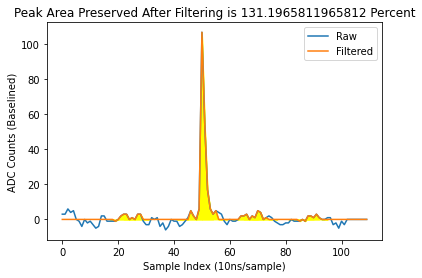

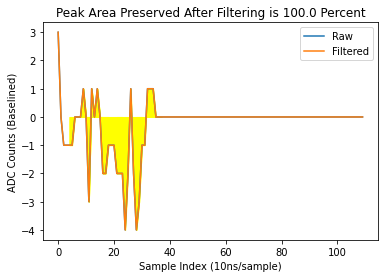

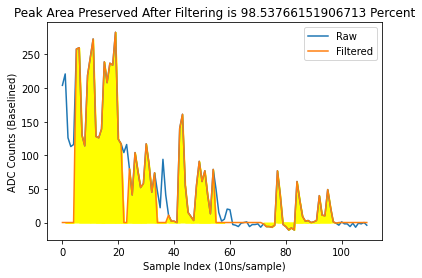

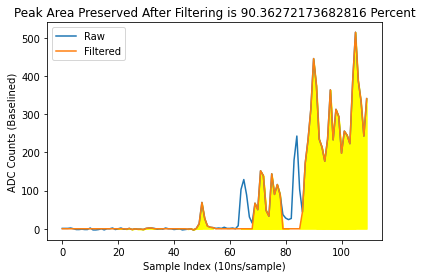

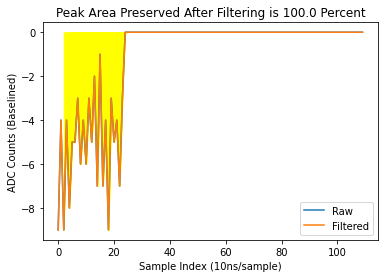

In [315]:
#print (raw_list)
#print (gau_list)

for i in range(0, 5):
    sum_raw = 0
    sum_gau = 0
    raw = raw_list[i][-1]
    gau = gau_list[i][-1]
    plt.plot(raw, label="Raw")
    plt.plot(gau, label="Filtered")
    p1s, prop1s = signal.find_peaks(raw)
    for p1 in p1s:
        sum_raw += sum(raw[p1-5:p1+5])
    p2s, prop2s = signal.find_peaks(gau)
    for p2 in p2s:
        sum_gau += sum(raw[p2-5:p2+5])
        if sum_gau != 0:
            x = [p2-5,p2-4,p2-3,p2-2,p2-1,p2,p2+1,p2+2,p2+3,p2+4]
            plt.fill_between(x, gau[p2-5:p2+5], color="yellow")
    plt.legend()
    plt.xlabel("Sample Index (10ns/sample)")
    plt.ylabel("ADC Counts (Baselined)")
    if sum_gau == 0:
        plt.title("No Valid Peaks Found by Gaussian Filter")
    else: 
        plt.title("Peak Area Preserved After Filtering is " + str(100*sum_gau/float(sum_raw)) + " Percent")
    plt.show()

Now let's plot out the area change before and after filtering:

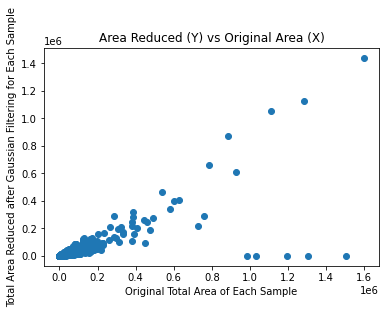

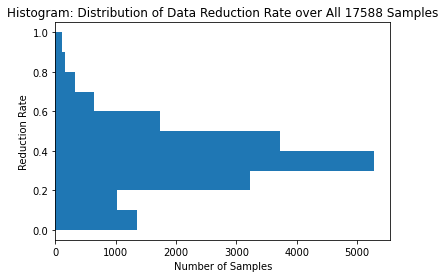

In [342]:
waveform_sum = []
gau_sum = []
diff = []
fraction = []

for chx in rm:
    for wf in chx:
        waveform_sum.append(sum(np.abs(wf[-1])))

for chx in r_matrix:
    for wf in chx:
        gau_sum.append(sum(np.abs(wf[-1])))

for i in range(len(waveform_sum)):
    diff.append(waveform_sum[i] - gau_sum[i])

for i in range(len(waveform_sum)):
    if diff[i] == 0:
        fraction.append(0.0)
    else:
        fraction.append(diff[i]/float(waveform_sum[i]))

plt.scatter(waveform_sum, diff)
plt.xlabel("Original Total Area of Each Sample")
plt.ylabel("Total Area Reduced after Gaussian Filtering for Each Sample")
plt.title("Area Reduced (Y) vs Original Area (X)")
plt.show()
plt.hist(fraction, orientation='horizontal')
plt.xlabel("Number of Samples")
plt.ylabel("Reduction Rate")
plt.title("Histogram: Distribution of Data Reduction Rate over All 17588 Samples")
plt.show()


On average, by using Gaussian Filter, we were able to reduce 0.36 percent of total area in the original signal (which were originally occupied by channel noises). 

We will provide the python function for each record (multiple samples at once) in a seperate python file. Function name will be called straxen.gaussian_filter(). 

Let's look at some other filters. The very first two filters people usually come up with are mean and median filters in image processing. Let's try them out: 

# 2. Median Filter


As one can refer from the name, a median filter takes an array, and replaces each value in this array with the median value around this value's k nearest neighbors. In this way, the value of a noise item in array can be smoothed by it's surrounding values. In the code below, we were using the default k value from scipy median filter. 

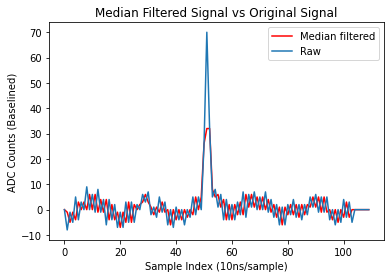

In [186]:
#Firstly we are going to implement a median filter:
from scipy.signal import medfilt
#taking record[0] as an example
med_filtered_example = medfilt(record[0][-1])
plt.plot(med_filtered_example,color="red", label="Median filtered")
plt.plot(record[0][-1], label='Raw')
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Median Filtered Signal vs Original Signal")
plt.legend()
plt.show()

The plot above shows the median-filtered signal in red and the unfiltered original signal in blue. Upon inspection we know that although noises are reduced, so does the pulse peaks (that we are looking for). Therefore median filter is not the ideal solution for us, although it's widely used in the field of image processing.  

# 3. Mean Filter

Similarly, a mean filter (also called moving average filter), replaces one value with the mean of k nearest neighbors (here we are using k=3) around it. Let's see the outcomes:

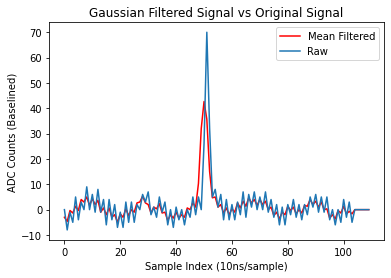

In [187]:
#Now let's implement a simple mean filter:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
plt.plot(runningMeanFast(record[0][-1], 3), color="red", label="Mean Filtered")
plt.plot(record[0][-1], label="Raw")
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Gaussian Filtered Signal vs Original Signal")
plt.legend()
plt.show()

Similar to what a median filter does, this filter averages and reduce the noise but also hurts the signal. With larger moving average coeffcient, the signal might be worsely disturbed. In this case, the SNR is not reduced and it should not be considered as our top choice of filtering. 

# 4. High and Low Pass Filters

Now let's look at the de-nosing problem from another prospective: As we saw earlier in the waveform, each piece of data contains one/multiple pulses and a series of channel noises. Due to the fact that channel noises are generated by the hardware power amplifers, the noises must have different frequencies than the actual signals. With this property, we can reduce noise level by using High-Pass/Low-Pass Filters. 

As a first step, we need to plot out the frequency response of the signal, in order to determine which frequencies are critical (or what's not). 

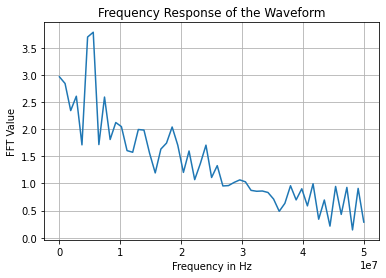

In [188]:
from scipy import signal
from scipy.fft import fft
from scipy.signal import butter, lfilter

N = 110
# sample spacing
T = 1e-8
x = np.linspace(0.0, N*T, N)
sample = record[0][-1]
yf = fft(sample)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel("Frequency in Hz")
plt.ylabel("FFT Value")
plt.title("Frequency Response of the Waveform")
plt.grid()
plt.show()

Sadly, if we look at the frequency specturm above, it's hard to see how noises are different from pulses (we are trying to find) in the frequency domain. But still, let's try some frequency based high-pass filtering: 

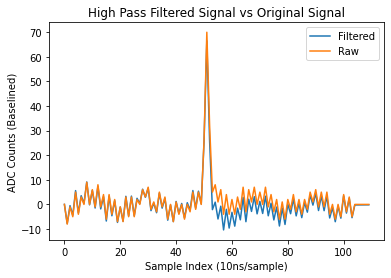

In [191]:
fs = 1e8 
cutoff = 0.1e7 # 10 MHz as the cutoff frequency
B, A = butter(1, cutoff / (fs / 2), btype='high') # 1st order Butterworth low-pass
filtered_signal = lfilter(B, A, record[0][-1], axis=0)
plt.plot(filtered_signal, label='Filtered')
plt.plot(record[0][-1], label='Raw')
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("High Pass Filtered Signal vs Original Signal")
plt.legend()
plt.show()

Oops! We have removed something, but definitely not what we expected; what if we increase the cutoff frequency?

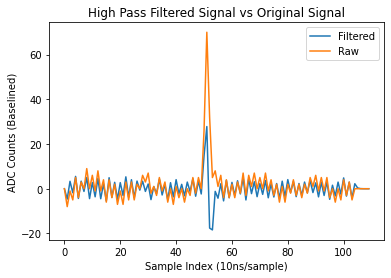

In [192]:
fs = 1e8 
cutoff = 2e7 # 10 MHz as the cutoff frequency
B, A = butter(1, cutoff / (fs / 2), btype='high') # 1st order Butterworth low-pass
filtered_signal = lfilter(B, A, record[0][-1], axis=0)
plt.plot(filtered_signal, label='Filtered')
plt.plot(record[0][-1], label='Raw')
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("High Pass Filtered Signal vs Original Signal")
plt.legend()
plt.show()

It's even ruining the signal! Besides, determining the cutoff frequency requires looking at the frequency specturm and is therefore time-cosuming (and not smart). Hence, we have to sadly abadon this frequency based filtering proposal, although this is a very good approach in many other cases. 

# 5. Wiener Filter

Finally, apart from frequency-based filters, Wiener filter is also used frequently for de-nosing. 

A Wiener filter computes a statistical estimate of an unknown signal using a related signal as an input and filtering that known signal to produce the estimate as an output. In our case, the filter estimated the noise level from average of the local variance of the input, and reducing it from the signal. An detailed introduction is provided here: https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-011-introduction-to-communication-control-and-signal-processing-spring-2010/readings/MIT6_011S10_chap11.pdf

To us developers, the theory behind wiener filter is too statistical to understand, but using it from scipy is not hard. See the code below:

/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


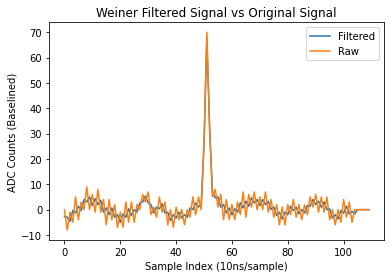

In [194]:
w_filtered = signal.wiener(record[0][-1])
plt.plot(w_filtered, label="Filtered") #filtered
plt.plot(record[0][-1], label="Raw") #original signal
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Weiner Filtered Signal vs Original Signal")
plt.legend()
plt.show()

This is nice. Compare with the previous gaussian filter approach, this wiener approach is more conservative, and takes less effort (won't have to specify noise for each channel). 

The gaussian filter above is, on the other hand, more aggresive, and should be used when storage is not enough. Finally let's time wiener filtering for the full record:

In [195]:
%%time
def wiener_filter(record):
    cp = record.copy()
    for item in cp:
        Wiener_filtered = signal.wiener(item[-1])
        item[-1] = Wiener_filtered
    return cp

record_filtered = wiener_filter(record)

/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in true_divide
  res *= (1 - noise / lVar)


CPU times: user 2.11 s, sys: 67.9 ms, total: 2.18 s
Wall time: 2.15 s


This runtime is similar but slower than gaussian filter; the difference is caused by the learning process (from variance) of the Wiener filter. 

# 6. Other Methods

In the end, there are still other filtering methods on the market, for exmaple, pypi library noisereduce, adaptive filters etc. But all these other options are way slower (~5 seconds per sample) than the approaches above (similar to using NN). This speed is far from being applied at large scale. 

Upon earlier experiments, we found technical difficulty using the noisereduce library with the default mode: our SNR is not large enough for the tool to distinguish between signal and noise (compared with voice signals). Refer to this site: https://pypi.org/project/noisereduce/

Adaptive Filters, similarly, requires deliberate hyperparametering. Refer to this site for more information: https://pypi.org/project/padasip/

Readers are more than welcomed to practice them, while we believe that gaussian and wiener filters are enough for the purpose of XENONnT processing. 

Gaussian and Wiener filters will be implemented in another python file and commited to strax ,due to their easness of use, speed & accuracy performance.  Users are expected to access them shortly. 

# 7 **Matched Filter (The baseline method we're comparing against)**

Team members mentioned about using Matched Filters. Here let's implement our own version of matched filter and compare the differences:

To build a matched filter, we need a template signal (which the filter trys to filter the noisy signal to), and in our case, it's a pulse. To obtain a perfect pulse, we have to eliminate noise in the template, as if we failed to do so, the noise specturm will also be included in the impulse response of template and hurts the filtering performance. Firstly, let's try to manually construct a perfect sample:

Using the first sample in channel 0 as an example, we already know that this sample contains pulse at position 50. 

(array([50]), {'peak_heights': array([62.])})


Text(0, 0.5, 'ADC Counts (Baselined)')

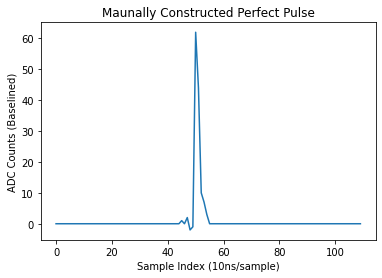

In [353]:
print (signal.find_peaks(rm[0][0][-1], 20))
perfect_pulse = np.array([0]*110)
perfect_pulse[45:55] = rm[0][0][-1][45:55]
#Now let's visualize it:
plt.plot(perfect_pulse)
plt.title("Maunally Constructed Perfect Pulse")
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")

Text(0.5, 1.0, 'Matched Filtered (Blue) vs Raw Signal')

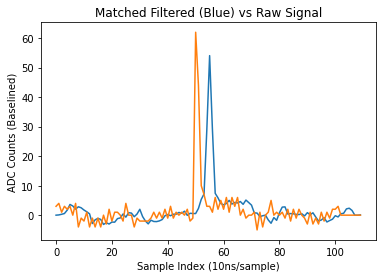

In [354]:
#Now let's use scipy.signal.correlate to perform matched filtering
corr = signal.correlate(rm[0][0][-1], perfect_pulse, mode='same') / 110
plt.plot(corr, label="Matched Filtered Result")
plt.plot(rm[0][0][-1], label="Raw")
plt.xlabel("Sample Index (10ns/sample)")
plt.ylabel("ADC Counts (Baselined)")
plt.title("Matched Filtered (Blue) vs Raw Signal")

The SNR was indeed increased: Noise was largely reduced compare to it's previous level, but the signal was shifted right and amplitude reduced. While the shifting fact is still accpetable, as the actual signal might have been shifted due to convolution with noise when passing throught the hardware, this matched filter stategy has it's problems:

1. It requires a perfect pulse. To construct a perfect pulse, one needs to go through every single sample in a run to ensure the quality of perfect pulse. Otherwise the amplitude (as well as FFT coefficients) will be harmed.
2. The peak's amplitude was reduced. The level of reduction is determined by channel noise, which is a uncontrollable factor. Therefore, we would never be able to know what's a good compensation level for the peak. 

Therefore, while matched fiters are very effective in general noise removing, we still believe that our proposed Gaussian and Wiener algorithms are better for the processing of our experiment data. 
